In [1]:
!pip install seaborn

In [2]:
# Cell 1: Setup and Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import os
from scipy.signal import butter, filtfilt, iirnotch, medfilt
import seaborn as sns

# Add the parent directory to the path to import project modules
sys.path.append('..')
from src import data_processing

# Configure matplotlib
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

In [3]:
# %% Cell 2: Load ECG Data
# Try to load previously processed data, or load raw data
try:
    processed_file = '../data/processed/ecg_signal.csv'
    df = pd.read_csv(processed_file)
    
    # Extract time and signal data
    time = df['Time (s)'].values
    
    # Detect channel columns
    channel_cols = [col for col in df.columns if col.startswith('Channel_')]
    
    if channel_cols:
        ecg_signal = df[channel_cols].values
        print(f"Loaded {len(channel_cols)} channels from {processed_file}")
    else:
        raise ValueError("No channel columns found")
    
    # Estimate sampling frequency
    fs = int(1 / (time[1] - time[0]))
    print(f"Estimated sampling frequency: {fs} Hz")
    
except Exception as e:
    print(f"Error loading processed data: {e}")
    
    # Generate synthetic data as fallback
    print("Creating synthetic ECG data...")
    fs = 250  # Hz
    duration = 10  # seconds
    
    # Time array
    time = np.arange(0, duration, 1/fs)
    
    # Create synthetic ECG with 12 heartbeats (approximately 72 BPM)
    ecg_signal = np.zeros((len(time), 2))  # Two channels
    
    # Create synthetic heartbeats
    for i in range(12):
        t_center = i * 0.83
        # QRS complex
        qrs_mask = (time > t_center - 0.03) & (time < t_center + 0.03)
        ecg_signal[qrs_mask, 0] = 1.5 * np.sin((time[qrs_mask] - t_center) * 150 + np.pi/2)
        ecg_signal[qrs_mask, 1] = 1.2 * np.sin((time[qrs_mask] - t_center) * 150 + np.pi/2)
        
        # P wave
        p_center = t_center - 0.15
        p_mask = (time > p_center - 0.05) & (time < p_center + 0.05)
        ecg_signal[p_mask, 0] += 0.25 * np.sin((time[p_mask] - p_center) * 100 + np.pi/2)
        ecg_signal[p_mask, 1] += 0.2 * np.sin((time[p_mask] - p_center) * 100 + np.pi/2)
        
        # T wave
        t_center = t_center + 0.2
        t_mask = (time > t_center - 0.1) & (time < t_center + 0.1)
        ecg_signal[t_mask, 0] += 0.35 * np.sin((time[t_mask] - t_center) * 50 + np.pi/2)
        ecg_signal[t_mask, 1] += 0.3 * np.sin((time[t_mask] - t_center) * 50 + np.pi/2)
    
    # Add baseline wander
    baseline_wander = 0.3 * np.sin(2 * np.pi * 0.05 * time)
    ecg_signal[:, 0] += baseline_wander
    ecg_signal[:, 1] += baseline_wander
    
    # Add powerline interference (50 Hz)
    powerline = 0.2 * np.sin(2 * np.pi * 50 * time)
    ecg_signal[:, 0] += powerline
    ecg_signal[:, 1] += powerline
    
    # Add noise
    ecg_signal[:, 0] += np.random.normal(0, 0.05, len(time))
    ecg_signal[:, 1] += np.random.normal(0, 0.04, len(time))

Loaded 2 channels from ../data/processed/ecg_signal.csv
Estimated sampling frequency: 360 Hz


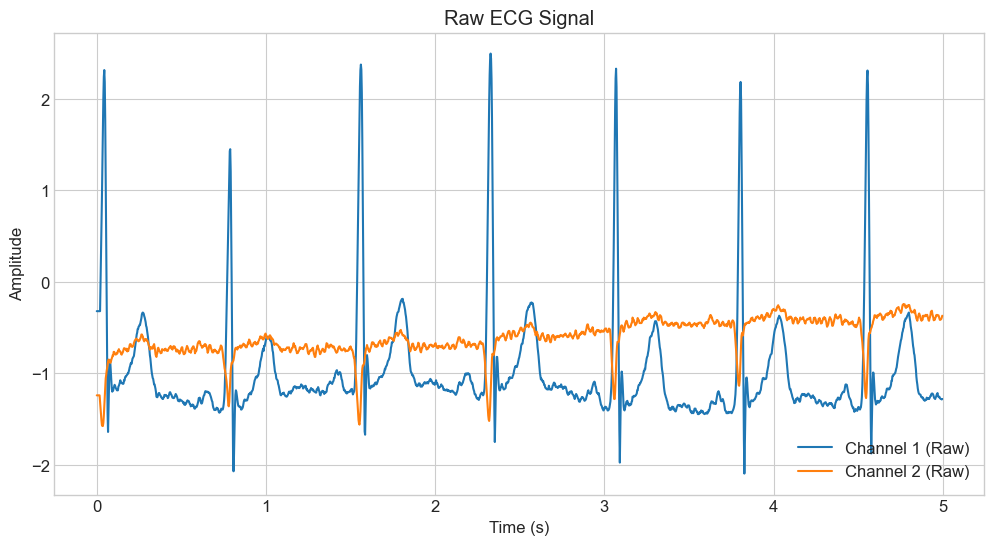

In [4]:
# %% Cell 3: Visualize Raw ECG Signal
# Plot the first 5 seconds of raw ECG signal
duration = 5  # seconds
samples = min(int(duration * fs), ecg_signal.shape[0])

plt.figure(figsize=(12, 6))
for channel in range(ecg_signal.shape[1]):
    plt.plot(time[:samples], ecg_signal[:samples, channel], label=f"Channel {channel+1} (Raw)")

plt.title("Raw ECG Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()

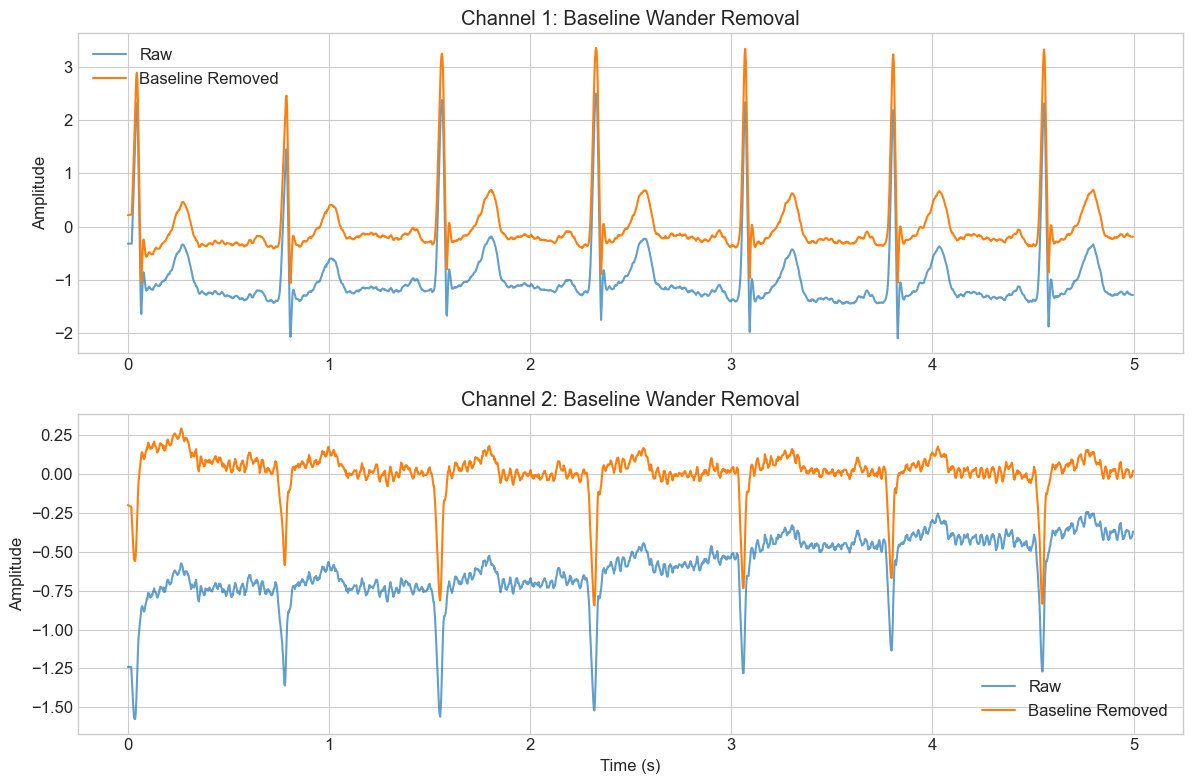

In [5]:
# %% Cell 4: Remove Baseline Wander
# Function from data_processing.py to remove baseline wander
def remove_baseline_wander(signal, fs=250):
    """
    Remove baseline wander using a high-pass filter.
    """
    cutoff = 0.5  # 0.5 Hz cutoff frequency
    nyquist = 0.5 * fs
    high_pass = cutoff / nyquist
    b, a = butter(1, high_pass, btype="high")
    if signal.ndim == 1:
        return filtfilt(b, a, signal)
    else:
        # Apply to each channel
        filtered_signal = np.zeros_like(signal)
        for channel in range(signal.shape[1]):
            filtered_signal[:, channel] = filtfilt(b, a, signal[:, channel])
        return filtered_signal

# Apply baseline wander removal
ecg_no_baseline = remove_baseline_wander(ecg_signal, fs)

# Plot comparison
plt.figure(figsize=(12, 8))
for channel in range(ecg_signal.shape[1]):
    plt.subplot(ecg_signal.shape[1], 1, channel+1)
    plt.plot(time[:samples], ecg_signal[:samples, channel], label="Raw", alpha=0.7)
    plt.plot(time[:samples], ecg_no_baseline[:samples, channel], label="Baseline Removed", linewidth=1.5)
    plt.title(f"Channel {channel+1}: Baseline Wander Removal")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)

plt.xlabel("Time (s)")
plt.tight_layout()
plt.show()


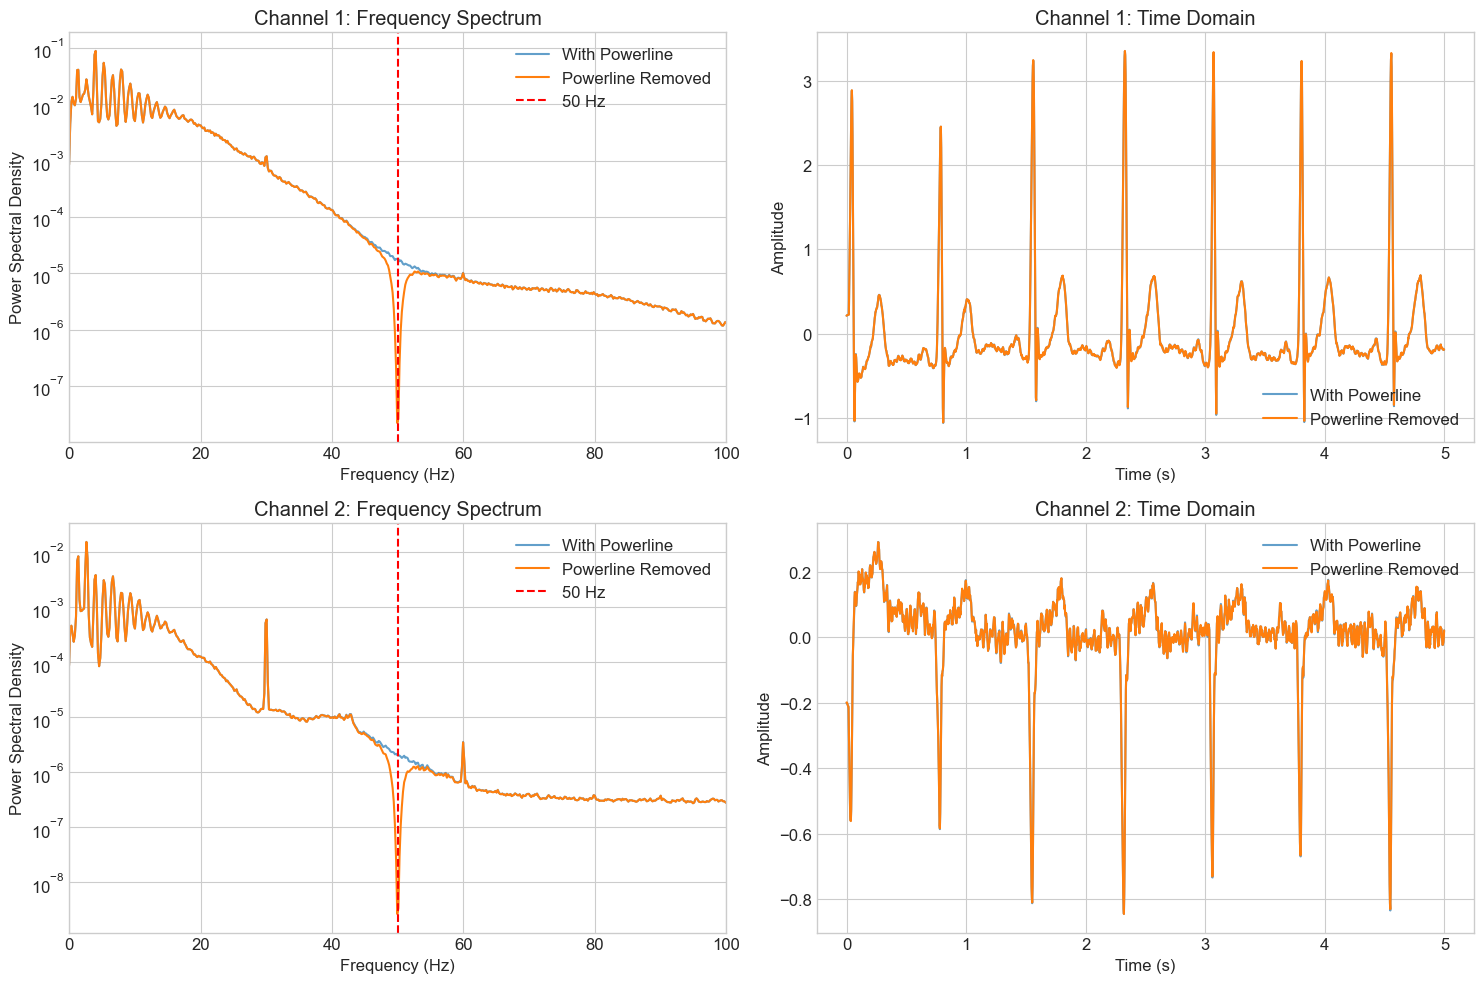

In [6]:
# %% Cell 5: Remove Powerline Interference
def remove_powerline_interference(signal, fs=250, freq=50):
    """
    Remove powerline interference using a notch filter.
    """
    q = 30.0  # Quality factor
    w0 = freq / (fs/2)
    b, a = iirnotch(w0, q)
    
    if signal.ndim == 1:
        return filtfilt(b, a, signal)
    else:
        # Apply to each channel
        filtered_signal = np.zeros_like(signal)
        for channel in range(signal.shape[1]):
            filtered_signal[:, channel] = filtfilt(b, a, signal[:, channel])
        return filtered_signal

# Apply powerline interference removal
ecg_no_powerline = remove_powerline_interference(ecg_no_baseline, fs, freq=50)

# Plot comparison in frequency domain
from scipy import signal as sig

plt.figure(figsize=(15, 10))
for channel in range(ecg_signal.shape[1]):
    # Raw signal PSD
    plt.subplot(ecg_signal.shape[1], 2, 2*channel+1)
    f, Pxx_raw = sig.welch(ecg_no_baseline[:, channel], fs, nperseg=2048)
    f, Pxx_filtered = sig.welch(ecg_no_powerline[:, channel], fs, nperseg=2048)
    
    plt.semilogy(f, Pxx_raw, label="With Powerline", alpha=0.7)
    plt.semilogy(f, Pxx_filtered, label="Powerline Removed", linewidth=1.5)
    plt.axvline(x=50, color='r', linestyle='--', label="50 Hz")
    plt.title(f"Channel {channel+1}: Frequency Spectrum")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power Spectral Density")
    plt.xlim([0, 100])  # Focus on 0-100 Hz range
    plt.legend()
    plt.grid(True)
    
    # Time domain
    plt.subplot(ecg_signal.shape[1], 2, 2*channel+2)
    plt.plot(time[:samples], ecg_no_baseline[:samples, channel], label="With Powerline", alpha=0.7)
    plt.plot(time[:samples], ecg_no_powerline[:samples, channel], label="Powerline Removed", linewidth=1.5)
    plt.title(f"Channel {channel+1}: Time Domain")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


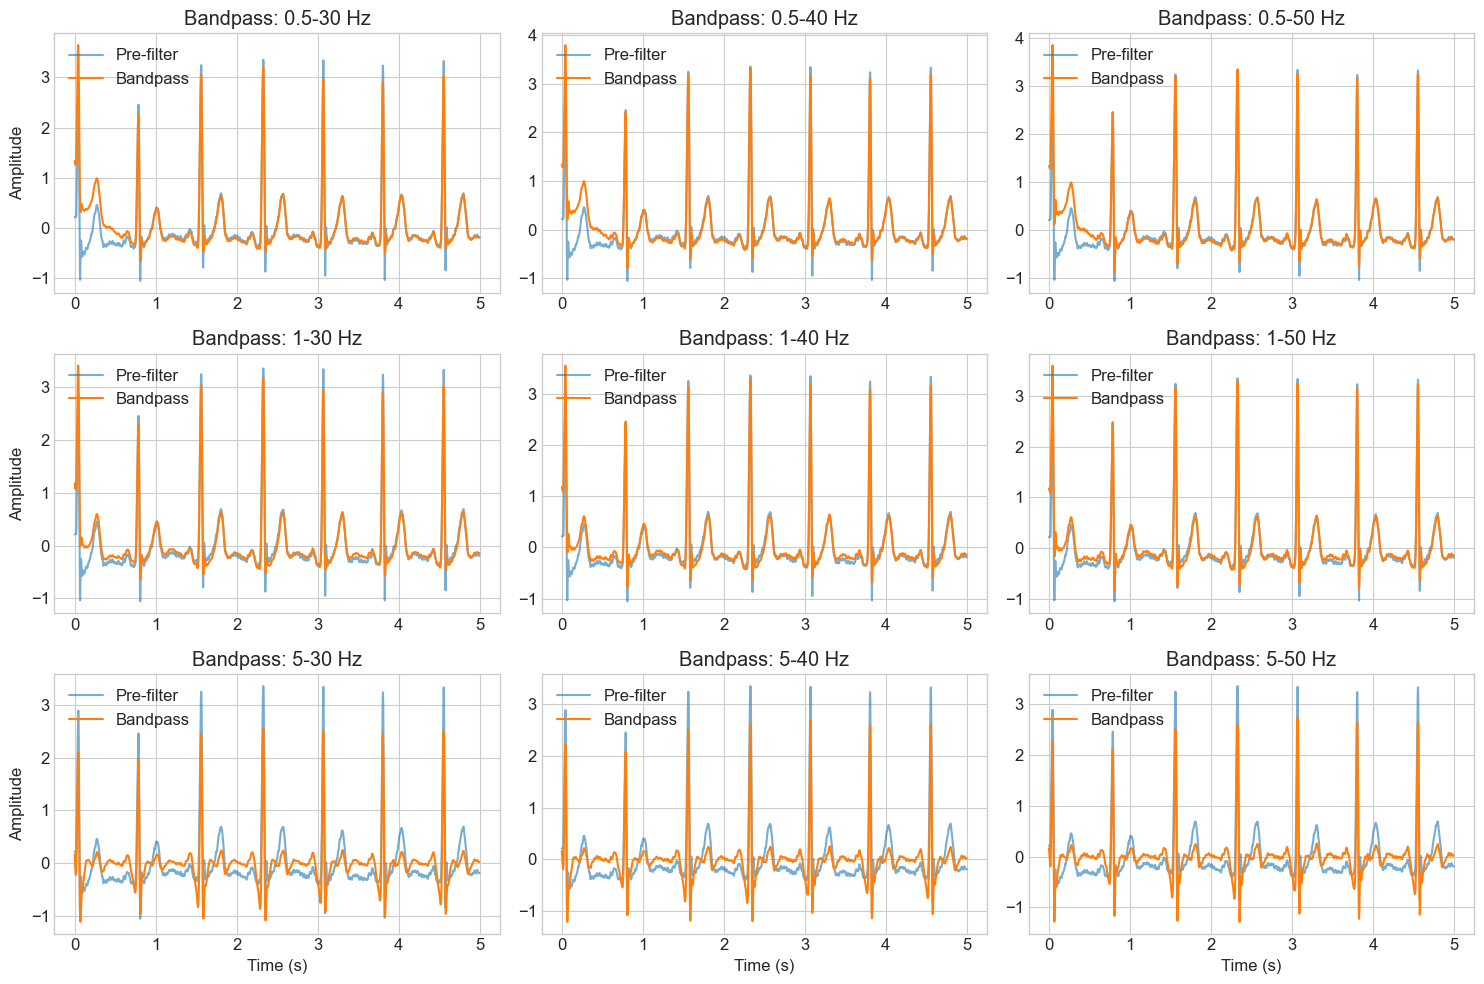

In [7]:
# %% Cell 6: Apply Bandpass Filter
def bandpass_filter(signal, lowcut=5, highcut=15, fs=250, order=2):
    """
    Apply bandpass filter to ECG signal.
    """
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype="band")
    
    if signal.ndim == 1:
        return filtfilt(b, a, signal)
    else:
        # Apply to each channel
        filtered_signal = np.zeros_like(signal)
        for channel in range(signal.shape[1]):
            filtered_signal[:, channel] = filtfilt(b, a, signal[:, channel])
        return filtered_signal

# Apply bandpass filter with different cutoff frequencies
lowcut_options = [0.5, 1, 5]
highcut_options = [30, 40, 50]

plt.figure(figsize=(15, 10))
channel_to_show = 0  # Show only the first channel for clarity

for i, lowcut in enumerate(lowcut_options):
    for j, highcut in enumerate(highcut_options):
        plt_idx = i * len(highcut_options) + j + 1
        
        # Apply bandpass filter
        ecg_bandpass = bandpass_filter(ecg_no_powerline, lowcut, highcut, fs)
        
        plt.subplot(len(lowcut_options), len(highcut_options), plt_idx)
        plt.plot(time[:samples], ecg_no_powerline[:samples, channel_to_show], label="Pre-filter", alpha=0.6)
        plt.plot(time[:samples], ecg_bandpass[:samples, channel_to_show], label="Bandpass", linewidth=1.5)
        plt.title(f"Bandpass: {lowcut}-{highcut} Hz")
        plt.xlabel("Time (s)" if i == len(lowcut_options)-1 else "")
        plt.ylabel("Amplitude" if j == 0 else "")
        plt.legend()
        plt.grid(True)

plt.tight_layout()
plt.show()

# Choose the best filter parameters (5-30 Hz is common for ECG)
lowcut, highcut = 5, 30
ecg_bandpass = bandpass_filter(ecg_no_powerline, lowcut, highcut, fs)


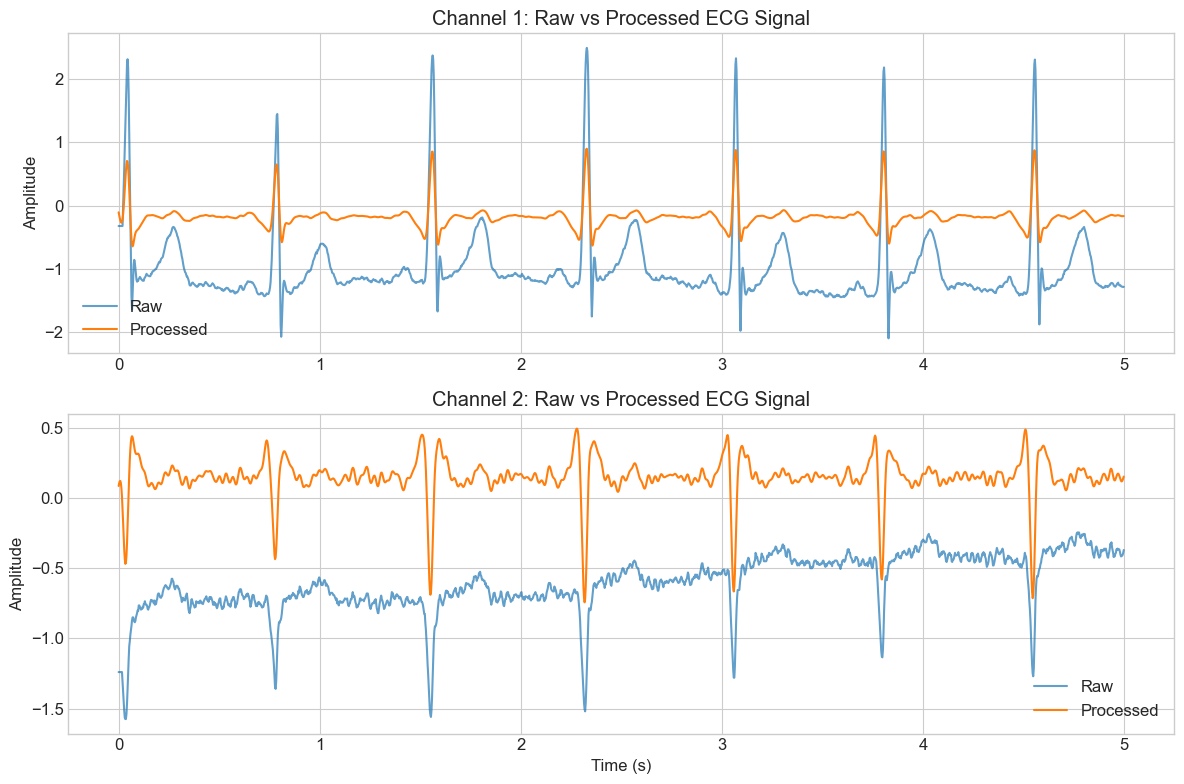

In [8]:
# %% Cell 7: Complete Signal Processing Pipeline
def preprocess_ecg(signal, fs=250, lowcut=5, highcut=30, powerline_freq=50):
    """
    Complete ECG preprocessing pipeline.
    """
    # Remove baseline wander
    signal = remove_baseline_wander(signal, fs)
    
    # Remove powerline interference
    signal = remove_powerline_interference(signal, fs, powerline_freq)
    
    # Apply bandpass filter
    signal = bandpass_filter(signal, lowcut, highcut, fs)
    
    # Normalize to range [-1, 1]
    for channel in range(signal.shape[1]):
        signal[:, channel] = 2 * (signal[:, channel] - np.min(signal[:, channel])) / (np.max(signal[:, channel]) - np.min(signal[:, channel])) - 1
    
    return signal

# Apply complete preprocessing pipeline
ecg_processed = preprocess_ecg(ecg_signal, fs)

# Plot raw vs processed signal
plt.figure(figsize=(12, 8))

for channel in range(ecg_signal.shape[1]):
    plt.subplot(ecg_signal.shape[1], 1, channel+1)
    plt.plot(time[:samples], ecg_signal[:samples, channel], label="Raw", alpha=0.7)
    plt.plot(time[:samples], ecg_processed[:samples, channel], label="Processed", linewidth=1.5)
    plt.title(f"Channel {channel+1}: Raw vs Processed ECG Signal")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)

plt.xlabel("Time (s)")
plt.tight_layout()
plt.show()



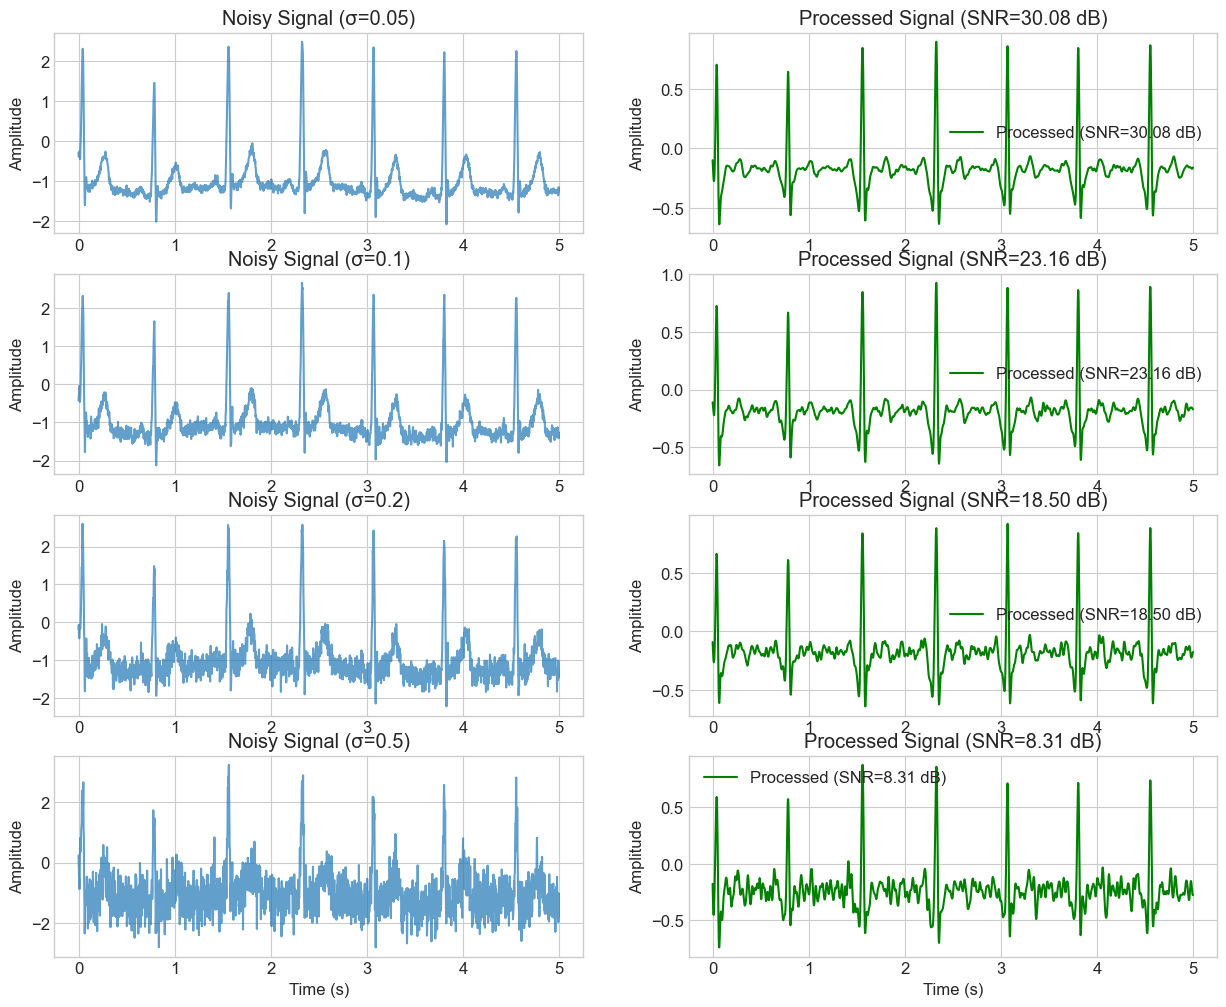

In [9]:
# %% Cell 8: Noise Sensitivity Analysis
# Add different levels of noise to see how the filtering performs
noise_levels = [0.05, 0.1, 0.2, 0.5]
channel_to_test = 0  # Test on first channel

plt.figure(figsize=(15, 12))

# Original clean signal (already processed)
reference_signal = ecg_processed[:, channel_to_test].copy()

for i, noise_level in enumerate(noise_levels):
    # Add noise to the original signal
    noisy_signal = ecg_signal[:, channel_to_test].copy()
    noisy_signal += np.random.normal(0, noise_level, len(noisy_signal))
    
    # Process the noisy signal
    processed_noisy = preprocess_ecg(noisy_signal.reshape(-1, 1), fs)[:, 0]
    
    # Calculate signal-to-noise ratio
    signal_power = np.mean(np.square(reference_signal))
    noise_power = np.mean(np.square(reference_signal - processed_noisy))
    snr = 10 * np.log10(signal_power / noise_power) if noise_power > 0 else float('inf')
    
    # Plot
    plt.subplot(len(noise_levels), 2, 2*i+1)
    plt.plot(time[:samples], noisy_signal[:samples], label=f"Noise σ={noise_level}", alpha=0.7)
    plt.title(f"Noisy Signal (σ={noise_level})")
    plt.xlabel("Time (s)" if i == len(noise_levels)-1 else "")
    plt.ylabel("Amplitude")
    plt.grid(True)
    
    plt.subplot(len(noise_levels), 2, 2*i+2)
    plt.plot(time[:samples], processed_noisy[:samples], label=f"Processed (SNR={snr:.2f} dB)", color='green')
    plt.title(f"Processed Signal (SNR={snr:.2f} dB)")
    plt.xlabel("Time (s)" if i == len(noise_levels)-1 else "")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)